In [1]:
# External - Directly used
import numpy as np
import matplotlib.pyplot as plt
import nuclei_func as nf
from scipy.interpolate import interp1d
from matplotlib import animation
from IPython.display import HTML

# External - Indirectly used in data or functions
import dill
import math
import copy

# Our functions
import loop

# Set working directory manually
import os
os.chdir('c:/Users/Simone Pagliuca/Documents/GitHub/NDT-Homeworks')

Call

In [2]:
############################################################################
# VARIABLES TO OPTIMIZE
thickness_cladding = 200e-6  # [m] - MAX Possible Value: 565e-6
h_plenum = 0.87# m
############################################################################
T_map, Geometrical_Data, He_percentage, Plenum_Pressure, Coolant_Velocity, Void_Swelling, params, Burnup, coolant_infinity_limit = loop.main(thickness_cladding, h_plenum)

Save_Data = True
    

Results

In [3]:
# Fuel Max Temperature
Max_Fuel_Temperature = np.max(T_map.T)
if Max_Fuel_Temperature > 2600 + 273.15:
    print(f"\033[91mMaximum Fuel Temperature = {Max_Fuel_Temperature} K, limit exceeded\033[0m")
else:
    print(f"\033[92mMaximum Fuel Temperature = {Max_Fuel_Temperature} K\033[0m")

# Cladding Max Temperature
cladding_midline_radii = [
    (Geometrical_Data.cladding_outer_diameter[i] / 2 +
    (Geometrical_Data.cladding_outer_diameter[i] / 2 - Geometrical_Data.thickness_cladding[i])) / 2
    for i in range(len(Geometrical_Data.h_values))
]
for i, radius in enumerate(cladding_midline_radii):
    # Interpolate temperature at the midline radius
    interp_func = interp1d(T_map.r[i, :], T_map.T[i, :], kind="linear", fill_value="extrapolate")
    temp_at_midline = interp_func(radius)
Max_Cladding = np.max(temp_at_midline)
if Max_Cladding > 650 + 273.15:
    print(f"\033[91mMaximum Cladding Temperature = {Max_Cladding} K, limit exceeded by {Max_Cladding - 650-273.15} K\033[0m")
else:
    print(f"\033[92mMaximum Cladding Temperature = {Max_Cladding} K\033[0m")

# Plenum Pressure
if Plenum_Pressure > 5e6:
    print(f"\033[91mPlenum Pressure = {Plenum_Pressure*1e-6} MPa, limit exceeded\033[0m")
else:
    print(f"\033[92mPlenum Pressure = {Plenum_Pressure*1e-6} MPa\033[0m")

# Istantaneous cladding plastic strain
#
#

# Maximum cladding volumetric swelling
Maximum_Cladding_Volumetric_Swelling = np.max(Void_Swelling)
if Maximum_Cladding_Volumetric_Swelling > 3:
    print(f"\033[91mMaximum Cladding Volumetric Swelling = {Maximum_Cladding_Volumetric_Swelling} %, limit exceeded \033[0m")
else:
    print(f"\033[92mMaximum Cladding Volumetric Swelling = {Maximum_Cladding_Volumetric_Swelling} %\033[0m")

# Maximum coolant velocity
Maximum_Coolant_Velocity = np.max(Coolant_Velocity)
if Maximum_Coolant_Velocity > 8:
    print(f"\033[91mMaximum Coolant Velocity = {Maximum_Coolant_Velocity} m/s, limit exceeded\033[0m")
else:
    print(f"\033[92mMaximum Coolant Velocity = {Maximum_Coolant_Velocity} m/s\033[0m")

# Gap thickness
Min_Gap_Thickness = np.min(np.array(Geometrical_Data.cladding_outer_diameter) / 2 - np.array(Geometrical_Data.fuel_outer_diameter) / 2 - np.array(Geometrical_Data.thickness_cladding))
if Min_Gap_Thickness <= 0:
    print(f"\033[91mGAP CLOSED\033[0m")
else:
    print(f"\033[92mMinimum Gap Thickness = {Min_Gap_Thickness*1e6} micron\033[0m")

Maximum Fuel Temperature = 2699.6567263363386 K
Maximum Cladding Temperature = 973.9765634365963 K, limit exceeded by 50.8265634365963 K
Plenum Pressure = 4.48511238345188 MPa
Maximum Cladding Volumetric Swelling = 2.524001450569369 %
Maximum Coolant Velocity = 7.21730074924387 m/s
GAP CLOSED


C:\Users\Simone Pagliuca\AppData\Local\Temp\ipykernel_15264\1503048093.py:42: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  fuel_outer_line.set_xdata(Geometrical_Data.fuel_outer_diameter[frame] / 2)
C:\Users\Simone Pagliuca\AppData\Local\Temp\ipykernel_15264\1503048093.py:43: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  fuel_inner_line.set_xdata(Geometrical_Data.fuel_inner_diameter[frame] / 2)
C:\Users\Simone Pagliuca\AppData\Local\Temp\ipykernel_15264\1503048093.py:44: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  cladding_outer_line.set_xdata(Geometrical_Data.cladding_outer_diameter[frame] / 2)
C:\Users\Simone Pagliuca\AppData\Local\Temp\ipykernel_15264\1503048093.py:45: MatplotlibDeprecationWarning: Setting dat

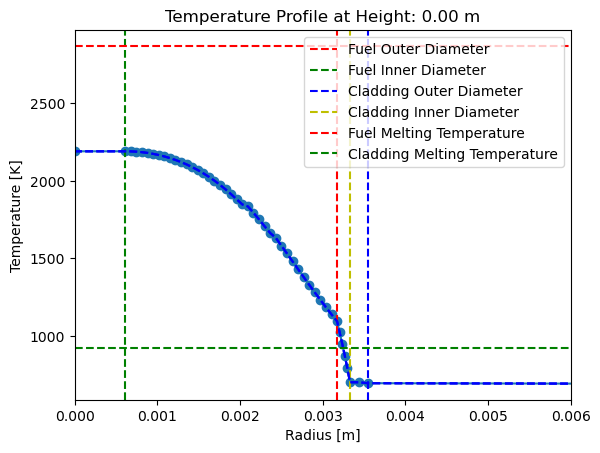

In [4]:
# Set up the figure and axis
fig, ax = plt.subplots()
ax.set_xlabel("Radius [m]")
ax.set_ylabel("Temperature [K]")

# Initialize lines and shadow container
line, = ax.plot([], [], marker='o')
shadow_lines = []

# Initialize vertical lines and legend
fuel_outer_line = ax.axvline(x=0, color='r', linestyle='--', label='Fuel Outer Diameter')
fuel_inner_line = ax.axvline(x=0, color='g', linestyle='--', label='Fuel Inner Diameter')
cladding_outer_line = ax.axvline(x=0, color='b', linestyle='--', label='Cladding Outer Diameter')
cladding_inner_line = ax.axvline(x=0, color='y', linestyle='--', label='Cladding Inner Diameter')
ax.axhline(y=2600 + 273, color='r', linestyle='--', label='Fuel Melting Temperature')
ax.axhline(y=650 + 273, color='g', linestyle='--', label='Cladding Melting Temperature')
ax.legend()

# Set limits for clarity
ax.set_xlim(0, coolant_infinity_limit)
ax.set_ylim(min(T_map.T.ravel()) - 100, 2600 + 273 + 100)

# Update function for each frame in the animation
def update(frame):
    # Clear previous shadows if they exist
    for shadow in shadow_lines:
        shadow.remove()
    shadow_lines.clear()

    # Current height and profiles
    height = T_map.h[frame] if T_map.h.ndim == 1 else T_map.h[frame, 0]
    radius_profile = T_map.r[frame, :]
    temperature_profile = T_map.T[frame, :]

    # Update title with current height
    ax.set_title(f"Temperature Profile at Height: {height:.2f} m")

    # Plot main line
    line.set_data(radius_profile, temperature_profile)

    # Update vertical line positions
    fuel_outer_line.set_xdata(Geometrical_Data.fuel_outer_diameter[frame] / 2)
    fuel_inner_line.set_xdata(Geometrical_Data.fuel_inner_diameter[frame] / 2)
    cladding_outer_line.set_xdata(Geometrical_Data.cladding_outer_diameter[frame] / 2)
    cladding_inner_line.set_xdata(Geometrical_Data.cladding_outer_diameter[frame] / 2 - Geometrical_Data.thickness_cladding[frame])

    # Create shadow effect with trailing profiles
    num_trails = 5  # Number of trailing lines
    for i in range(1, num_trails + 1):
        trail_frame = max(0, frame - i)
        trail_opacity = 1 - (i / (num_trails + 1))
        shadow, = ax.plot(T_map.r[trail_frame, :], T_map.T[trail_frame, :], color='blue', alpha=trail_opacity, linestyle='--')
        shadow_lines.append(shadow)

    return line, fuel_outer_line, fuel_inner_line, cladding_outer_line, cladding_inner_line, *shadow_lines

# Create the animation with blit disabled
ani = animation.FuncAnimation(fig, update, frames=len(T_map.h), blit=False, repeat=True, interval=70, repeat_delay=1000)

if Save_Data:
    # Save as gif
    ani.save("Temperature_Profile.gif", writer="pillow", fps=10)
    
# Display the animation in the notebook
HTML(ani.to_jshtml())



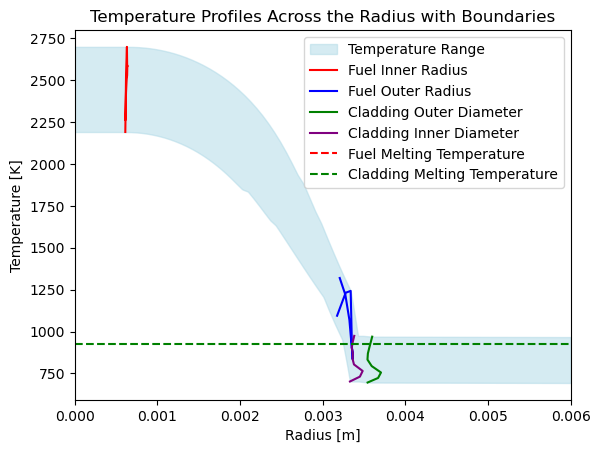

In [5]:
# Set up the figure and axis
fig, ax = plt.subplots()
ax.set_xlabel("Radius [m]")
ax.set_ylabel("Temperature [K]")

# Convert T_map.r to a numeric NumPy array if not already
T_map.r = np.array([np.array(row, dtype=float) for row in T_map.r], dtype=object)

# Define a common radius grid
common_radius = np.linspace(0, coolant_infinity_limit, 500)  # 500 points from 0 to 6 mm

# Interpolate profiles to the common radius grid
interpolated_profiles = []
for i in range(len(T_map.r)):
    if len(T_map.r[i]) > 1:  # Only interpolate if there are sufficient points
        interp_func = interp1d(
            T_map.r[i], T_map.T[i, :], kind="linear", fill_value="extrapolate"
        )
        interpolated_profiles.append(interp_func(common_radius))
    else:
        interpolated_profiles.append(np.full_like(common_radius, np.nan))  # Handle empty rows

# Ensure interpolated_profiles is a valid numeric array
interpolated_profiles = np.array(interpolated_profiles, dtype=float)

# Compute minimum and maximum temperature at each radius
with np.errstate(invalid='ignore'):  # Suppress warnings for NaN handling
    min_temperature = np.nanmin(interpolated_profiles, axis=0)
    max_temperature = np.nanmax(interpolated_profiles, axis=0)

# Ensure common_radius, min_temperature, and max_temperature are valid numeric arrays
min_temperature = np.array(min_temperature, dtype=float)
max_temperature = np.array(max_temperature, dtype=float)

# Mask for valid values
valid_mask = np.isfinite(min_temperature) & np.isfinite(max_temperature)

ax.fill_between(
    common_radius[valid_mask],
    min_temperature[valid_mask],
    max_temperature[valid_mask],
    color="lightblue",
    alpha=0.5,
    label="Temperature Range",
)

# Compute interface radii and corresponding temperatures
fuel_inner_radius = np.array(
    [Geometrical_Data.fuel_inner_diameter[i] / 2 for i in range(len(Geometrical_Data.h_values))]
)
fuel_outer_radius = np.array(
    [Geometrical_Data.fuel_outer_diameter[i] / 2 for i in range(len(Geometrical_Data.h_values))]
)
cladding_outer_diameter = np.array(
    [Geometrical_Data.cladding_outer_diameter[i] / 2 for i in range(len(Geometrical_Data.h_values))]
)
cladding_inner_diameter = np.array(
    [
        Geometrical_Data.cladding_outer_diameter[i] / 2 - Geometrical_Data.thickness_cladding[i]
        for i in range(len(Geometrical_Data.h_values))
    ]
)

# Interpolate temperatures for interface points
def interpolate_temp(radius_list):
    temperatures = []
    for i, radius in enumerate(radius_list):
        if len(T_map.r[i]) > 1:
            interp_func = interp1d(
                T_map.r[i], T_map.T[i, :], kind="linear", fill_value="extrapolate"
            )
            temperatures.append(interp_func(radius))
        else:
            temperatures.append(np.nan)  # Handle invalid radii
    return np.array(temperatures, dtype=float)

fuel_inner_temps = interpolate_temp(fuel_inner_radius)
fuel_outer_temps = interpolate_temp(fuel_outer_radius)
cladding_outer_temps = interpolate_temp(cladding_outer_diameter)
cladding_inner_temps = interpolate_temp(cladding_inner_diameter)

# Plot the interface lines
ax.plot(
    fuel_inner_radius,
    fuel_inner_temps,
    color="red",
    linestyle="-",
    label="Fuel Inner Radius",
)
ax.plot(
    fuel_outer_radius,
    fuel_outer_temps,
    color="blue",
    linestyle="-",
    label="Fuel Outer Radius",
)
ax.plot(
    cladding_outer_diameter,
    cladding_outer_temps,
    color="green",
    linestyle="-",
    label="Cladding Outer Diameter",
)
ax.plot(
    cladding_inner_diameter,
    cladding_inner_temps,
    color="purple",
    linestyle="-",
    label="Cladding Inner Diameter",
)

# Add melting temperature lines
t_melt_fuel_line = ax.axhline(
    y=2600 + 273, color="r", linestyle="--", label="Fuel Melting Temperature"
)
t_melt_cladding_line = ax.axhline(
    y=650 + 273, color="g", linestyle="--", label="Cladding Melting Temperature"
)

# Set limits for clarity
ax.set_xlim(0, coolant_infinity_limit)
ax.set_ylim(np.nanmin(min_temperature) - 100, np.nanmax(max_temperature) + 100)

# Add title and legend
ax.set_title("Temperature Profiles Across the Radius with Boundaries")
ax.legend()

# Show the plot
plt.show()

if Save_Data:
    fig.savefig("static_temperature_profiles_with_boundaries.png", dpi=300)

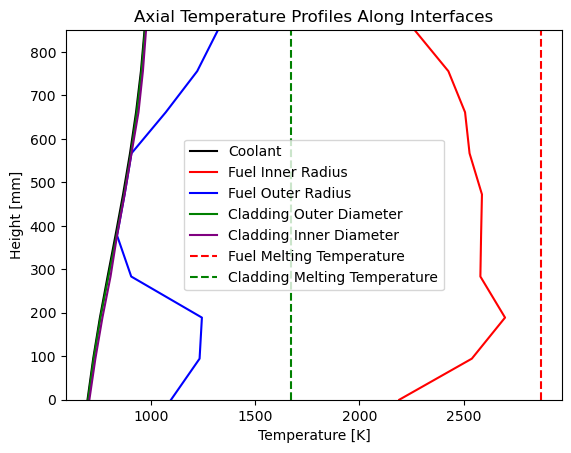

In [8]:
# Set up the figure and axis
fig, ax = plt.subplots()
ax.set_xlabel("Temperature [K]")
ax.set_ylabel("Height [mm]")

# Extract temperature profiles along the height for each interface
def get_axial_temperature_profiles(interface_radii):
    temperatures = []
    for i, radius in enumerate(interface_radii):
        interp_func = interp1d(T_map.r[i, :], T_map.T[i, :], kind="linear", fill_value="extrapolate")
        temperatures.append(interp_func(radius))
    return temperatures

# Compute axial temperatures for each interface
coolant_temps = get_axial_temperature_profiles([coolant_infinity_limit for i in range(len(Geometrical_Data.h_values))])
fuel_inner_temps = get_axial_temperature_profiles(
    [Geometrical_Data.fuel_inner_diameter[i] / 2 for i in range(len(Geometrical_Data.h_values))]
)
fuel_outer_temps = get_axial_temperature_profiles(
    [Geometrical_Data.fuel_outer_diameter[i] / 2 for i in range(len(Geometrical_Data.h_values))]
)
cladding_outer_temps = get_axial_temperature_profiles(
    [Geometrical_Data.cladding_outer_diameter[i] / 2 for i in range(len(Geometrical_Data.h_values))]
)
cladding_inner_temps = get_axial_temperature_profiles(
    [
        Geometrical_Data.cladding_outer_diameter[i] / 2 - Geometrical_Data.thickness_cladding[i]
        for i in range(len(Geometrical_Data.h_values))
    ]
)

# Height values in mm
h_vals_mm = Geometrical_Data.h_values * 1e3

# Plot the temperature profiles along the height
ax.plot(coolant_temps, h_vals_mm, color="black", linestyle="-", label="Coolant")
ax.plot(fuel_inner_temps, h_vals_mm, color="red", linestyle="-", label="Fuel Inner Radius")
ax.plot(fuel_outer_temps, h_vals_mm, color="blue", linestyle="-", label="Fuel Outer Radius")
ax.plot(cladding_outer_temps, h_vals_mm, color="green", linestyle="-", label="Cladding Outer Diameter")
ax.plot(cladding_inner_temps, h_vals_mm, color="purple", linestyle="-", label="Cladding Inner Diameter")

# Plot reference horizontal lines for melting temperatures
MM_fuel = nf.mixture(
    params["Fuel_Proprieties"].Molar_Mass,
    params["Fuel_Proprieties"].Qualities,
    normalization_cond="normalize",
)
pu_weight = nf.mol2w([params["Fuel_Proprieties"].Qualities[-1]], [MM_fuel])[0]
dev_stechiometry = 2 - params["Fuel_Proprieties"].Oxigen_to_metal_ratio
T_fuel_melt = params["Fuel_Proprieties"].Melting_Temperature(
    pu_weight, dev_stechiometry, Burnup
)
t_cladding_melt = params["Cladding_Proprieties"].Melting_Temperature

ax.axvline(x=2600 + 273, color="r", linestyle="--", label="Fuel Melting Temperature")
ax.axvline(x=1673, color="g", linestyle="--", label="Cladding Melting Temperature")

# Set plot limits and labels
ax.set_xlim(min(T_map.T.ravel()) - 100, 2600 + 273 + 100)
ax.set_ylim(0, max(h_vals_mm))
ax.set_title("Axial Temperature Profiles Along Interfaces")
ax.legend()

# Save the plot
plt.show()

if Save_Data:
    fig.savefig("axial_temperature_profiles_along_interfaces.png", dpi=300)